# Cell Classification - End Model (LSTM)

In this notebook we use the labeled data generated using snorkel in the previous notebook ([here](Exploration_and_WeakSupervision.ipynb)) to train a supervised LSTM model that will classify a given cell source code into the relevant data-scientist workflow stage (multi-class text classification). 

In [ ]:
# install necessary packages
! pip install -U --user pip six numpy wheel mock pandas
! pip install -U --user keras_applications==1.0.6 --no-deps
! pip install -U --user keras_preprocessing==1.0.5 --no-deps
! pip install keras tensorflow sklearn

this should work, but if any problems occur see- [https://www.tensorflow.org/install](https://www.tensorflow.org/install), [https://keras.io/#installation](https://keras.io/#installation)

In [1]:
# First let's import relevant libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.models import Sequential
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.metrics import mean_squared_error
from keras.models import load_model

# Input data files are available in the "../input/" directory.
import os
print(os.listdir("input/"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['cells.tsv', 'gold_labels.tsv', 'input.tsv', 'notebooks.csv', 'tagged_to_gold.tsv', '__pycache__']


*If keras and tensorflow installation was succesful and there is still a problem with the imports, try restarting the kernel and clearing outputs, and then run the imports cell again.

In [2]:
# load our tagged Data
data = pd.read_csv('input/input.tsv', delimiter='\t', usecols=['Cell ID', 'Source', 'Label'])

## Pre-Processing

In [3]:
#first we'll remove cells that snorkel didn't tag
data.dropna(subset=['Label'], how='all', inplace = True)
data = data[data.Label != 'Unknown']

In [4]:
#now let's take a look at some random cells
data.sample(5)

,Cell ID,Source,Label
30342,frizzles7_#_intro-home-credit-default-risk_#_36,(dataset['DAYS_EMPLOYED']).describe(),Explore
53670,yifanxie_#_porto-seguro-tutorial-end-to-end-en...,"['logit_lv2=LogisticRegression(random_state=0,...",Train
26442,cyyysw_#_health-care-insurance_#_1,# This Python 3 environment comes with many he...,Import
88881,kerneler_#_starter-world-bank-quarterly-extern...,"plotPerColumnDistribution(df3, 10, 5)",Explore
45995,harrypotter0_#_a-simple-nn-solution-with-keras...,#KERAS DATA DEFINITION\r\r\r\nfrom keras.prepr...,Prep


### Class Imbalance

let's take a look at the tagged data value counts

In [5]:
#now let's see
data.Label.value_counts()

Explore    33918
Prep       18027
Load        7965
Import      7688
Eval        5106
Train       4823
Name: Label, dtype: int64

We can see the classes are imbalanced. The data exploration class has much more cells than the others. we want to have balaced classes for the model to train, so we'll take a fixed size from each class (under sample the large classes).

In [6]:
# first we shuffle the data by randomly re-indexing
shuffled = data.reindex(np.random.permutation(data.index))
shuffled.head(5) #check data is indeed shuffeled


,Cell ID,Source,Label
70046,anjaligautam_#_summary-functions-and-maps-work...,Reviews_2 = reviews.loc[(reviews.country.isnul...,Prep
67891,thatsrich_#_data-exploration_#_7,print (market_obs_df.shape)\r\r\r\n \r\r\r\...,Explore
38996,sociopath00_#_notebook551a15e490_#_2,"['data = pd.read_csv(""../input/kc_house_data.c...",Load
12445,pierrek20_#_algorithms-selection-to-predict-fr...,print( pd.DataFrame ( {'NB' : selection_data.g...,Explore
329,kerneler_#_starter-advance-u-s-international-f...,nRowsRead = 1000 # specify 'None' if want to r...,Load


In [7]:
fixed_class_size = 5000 #the fixed size was selected by trial and error
l  = shuffled[shuffled['Label'] == 'Load'][:fixed_class_size]
p  = shuffled[shuffled['Label'] == 'Prep'][:fixed_class_size]
t  = shuffled[shuffled['Label'] == 'Train'][:fixed_class_size]
ev = shuffled[shuffled['Label'] == 'Eval'][:fixed_class_size]
ex = shuffled[shuffled['Label'] == 'Explore'][:fixed_class_size]
i  = shuffled[shuffled['Label'] == 'Import'][:fixed_class_size]

concated = pd.concat([l, p, t, ev, ex, i], ignore_index=True) #our new data with balanced classes
concated.head(5)

,Cell ID,Source,Label
0,sociopath00_#_notebook551a15e490_#_2,"['data = pd.read_csv(""../input/kc_house_data.c...",Load
1,kerneler_#_starter-advance-u-s-international-f...,nRowsRead = 1000 # specify 'None' if want to r...,Load
2,alfazick_#_method-chaining_#_1,import pandas as pd\r\r\r\npd.set_option('max_...,Load
3,blackbee2016_#_good-fun-with-automation_#_1,import pandas as pd\r\r\r\ntrain = pd.read_csv...,Load
4,jupyteryoda_#_should-i-invest-with-lending-clu...,"['# read in data from CSV file\n', ""df = pd.re...",Load


In [8]:
#Shuffle the dataset again by re-indexing
concated = concated.reindex(np.random.permutation(concated.index))
concated.head(5)

,Cell ID,Source,Label
7795,javiermortiz_#_indexing-selecting-assigning-0b...,reviews[reviews.region_2.notnull()],Prep
21148,santoshgaikwad_#_santosh-google-competition-ke...,ax = sd['trafficSource.source'].value_counts()...,Explore
12095,lilykahler_#_credit-card-fraud-detection-using...,from itertools import cycle\r\r\r\nfrom sklear...,Train
28687,aantonova_#_aggregating-all-tables-in-one-data...,import numpy as np\r\r\r\nimport pandas as pd,Import
7949,ayush16_#_summary-functions-and-maps-workbook-...,# Your code here\r\r\r\nreviews.ppr=[]\r\r\r\n...,Prep


### Tokenization and Vector representation of label and code

We'll represent the label as a one-hot vector

In [9]:
#add int representation of the label
concated['INT'] = 0
concated.loc[concated['Label'] == 'Load', 'INT']  = 0
concated.loc[concated['Label'] == 'Prep', 'INT']  = 1
concated.loc[concated['Label'] == 'Train', 'INT']  = 2
concated.loc[concated['Label'] == 'Eval', 'INT'] = 3
concated.loc[concated['Label'] == 'Explore', 'INT'] = 4
concated.loc[concated['Label'] == 'Import', 'INT']  = 5

#one-hot encode the label
labels = to_categorical(concated['INT'], num_classes=6)
if 'Label' in concated.keys():
    concated.drop(['Label'], axis=1)
# '''
#  [1. 0. 0. 0. 0. 0.] load data
#  [0. 1. 0. 0. 0. 0.] data preparation and cleaning
#  [0. 0. 1. 0. 0. 0.] model training and parameter tuning
#  [0. 0. 0. 1. 0. 0.] model evaluation
#  [0. 0. 0. 0. 1. 0.] data exploration
#  [0. 0. 0. 0. 0. 1.] imports
# '''

#let's print some of the labels to see the encoding
labels.view()

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

We remove all comments, as comments may refer to actions that weren’t really done or to what was done previously to the current cell, so that it just interferes in our task to classify the current cell correctly.

In [12]:
from utils.utils import findAndRemoveComments
concated['Source'] = concated['Source'].apply(lambda x: findAndRemoveComments(x))

Now we turn the code to-lower, filter special chars and dots and split each cell's code into tokens.
Then we represent the most common words by ints and each cell is represented as a vector of ints according to the words that it contains. The vectors are then padded to a fixed max length of 100.

In [13]:
n_most_common_words = 8000
max_len = 120
tokenizer = Tokenizer(num_words=n_most_common_words, filters='!"#$%&()*+,.-/:;<=>?@[\]^`{|}~\n\r\t \'', lower=True)
tokenizer.fit_on_texts(concated['Source'].values)
sequences = tokenizer.texts_to_sequences(concated['Source'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
print("-------")
print(word_index) #our "words" dictionary

X = pad_sequences(sequences, maxlen=max_len)

Found 48158 unique tokens.
-------
{'n': 1, '0': 2, '1': 3, 'import': 4, 'data': 5, 'pd': 6, 'print': 7, 'np': 8, 'as': 9, 'df': 10, 'from': 11, 'plt': 12, 'in': 13, 'input': 14, 'csv': 15, 'for': 16, 'train': 17, 'x': 18, 'the': 19, '2': 20, 'model': 21, 'read_csv': 22, 'columns': 23, 'sklearn': 24, 'test': 25, 'i': 26, '5': 27, 'shape': 28, 'true': 29, 'if': 30, 'to': 31, 'values': 32, 'y': 33, 'x_train': 34, 'pandas': 35, 'fit': 36, 'predict': 37, 'and': 38, 'of': 39, 'y_train': 40, 'reviews': 41, 'x_test': 42, '3': 43, 'numpy': 44, 'len': 45, 'col': 46, '10': 47, 'mean': 48, 'are': 49, 'def': 50, 'axis': 51, 'time': 52, 'matplotlib': 53, 'return': 54, 'y_test': 55, 'c': 56, 'ax': 57, 'false': 58, 'dataframe': 59, 'none': 60, 'score': 61, 'sns': 62, 'target': 63, 'loc': 64, 'f': 65, 'self': 66, 'plot': 67, 'index': 68, 'rows': 69, 'head': 70, 'drop': 71, 'append': 72, 'ncol': 73, '100': 74, 'metrics': 75, 'xgb': 76, 'tf': 77, 'y_pred': 78, '1000': 79, '8': 80, 'nrow': 81, 'os': 82, 

Now we split the data, represented as vectors, into train and test sets.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X , labels, test_size=0.25, random_state=42)

## LSTM Model

Now we setup and train an LSTM model using the vector representation of the code and the labels.

#### Parameter Definitions

In [15]:
epochs = 15
# we set an EarlyStopping, so when the model stops improving val_loss'wise it will stop training
# but we also don't want to overfit
emb_dim = 512
batch_size = 256

#### Model Setup and Training
<u>Note: model training could take up to 1 hour, you can skip and load the trained model in the next cell</u>

In [17]:
print("(X_train.shape, y_train.shape, X_test.shape, y_test.shape)")
print((X_train.shape, y_train.shape, X_test.shape, y_test.shape))
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.8))
model.add(LSTM(64, dropout=0.8, recurrent_dropout=0.8))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc', mean_squared_error])
print(model.summary())
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_acc',patience=7, min_delta=0.0001)])

(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
((22367, 120), (22367, 6), (7456, 120), (7456, 6))
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 512)          4096000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 120, 512)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                147712    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 4,244,102
Trainable params: 4,244,102
Non-trainable params: 0
_________________________________________________________________
None
Train on 17893 samples, validate on 4474 samples
Epoch 1/15
17893/17893 [==============================] - 220s 12ms/step - loss: 1.6803 - acc: 0.350

In [18]:
model.save('LSTM.h5') #save the trained model

#### load the trained model (continue here if you don't train the model)

In [19]:
#load the trained model (not needed if you train again)
model = load_model('LSTM.h5')

## Model Evaluation

In [20]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7456/7456 [==============================] - 27s 4ms/step
Test set
  Loss: 0.439
  Accuracy: 0.867


We get a Categorical Accuracy of 86.7% - that means we get the class right for 86.7% of the cells, that's great!
We could see during training that the MSE of the training set is similar to that of the validation set, so we figure the model isn't too overfitted.
We optimised the model by Categorical Cross-Entropy Loss as we are classifying with softmax output node activation.
We Can see the model convergence:

<IPython.core.display.Javascript object>


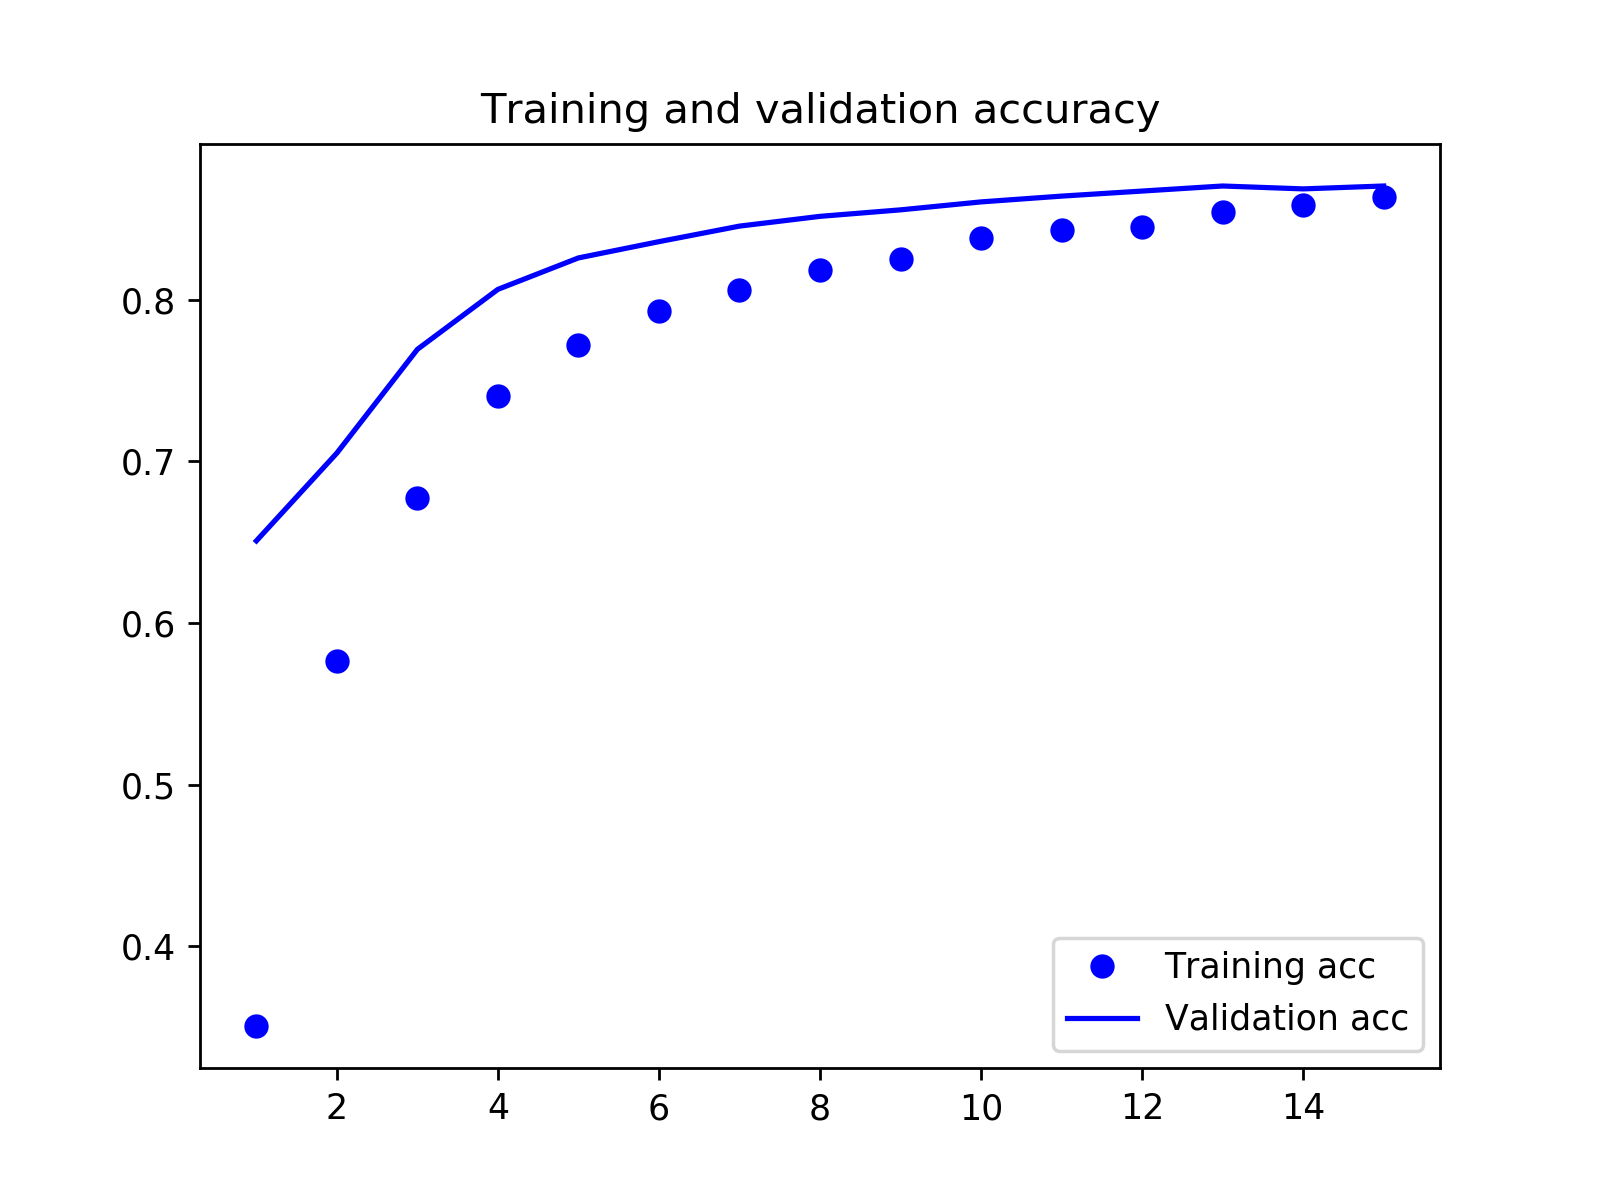

<IPython.core.display.Javascript object>


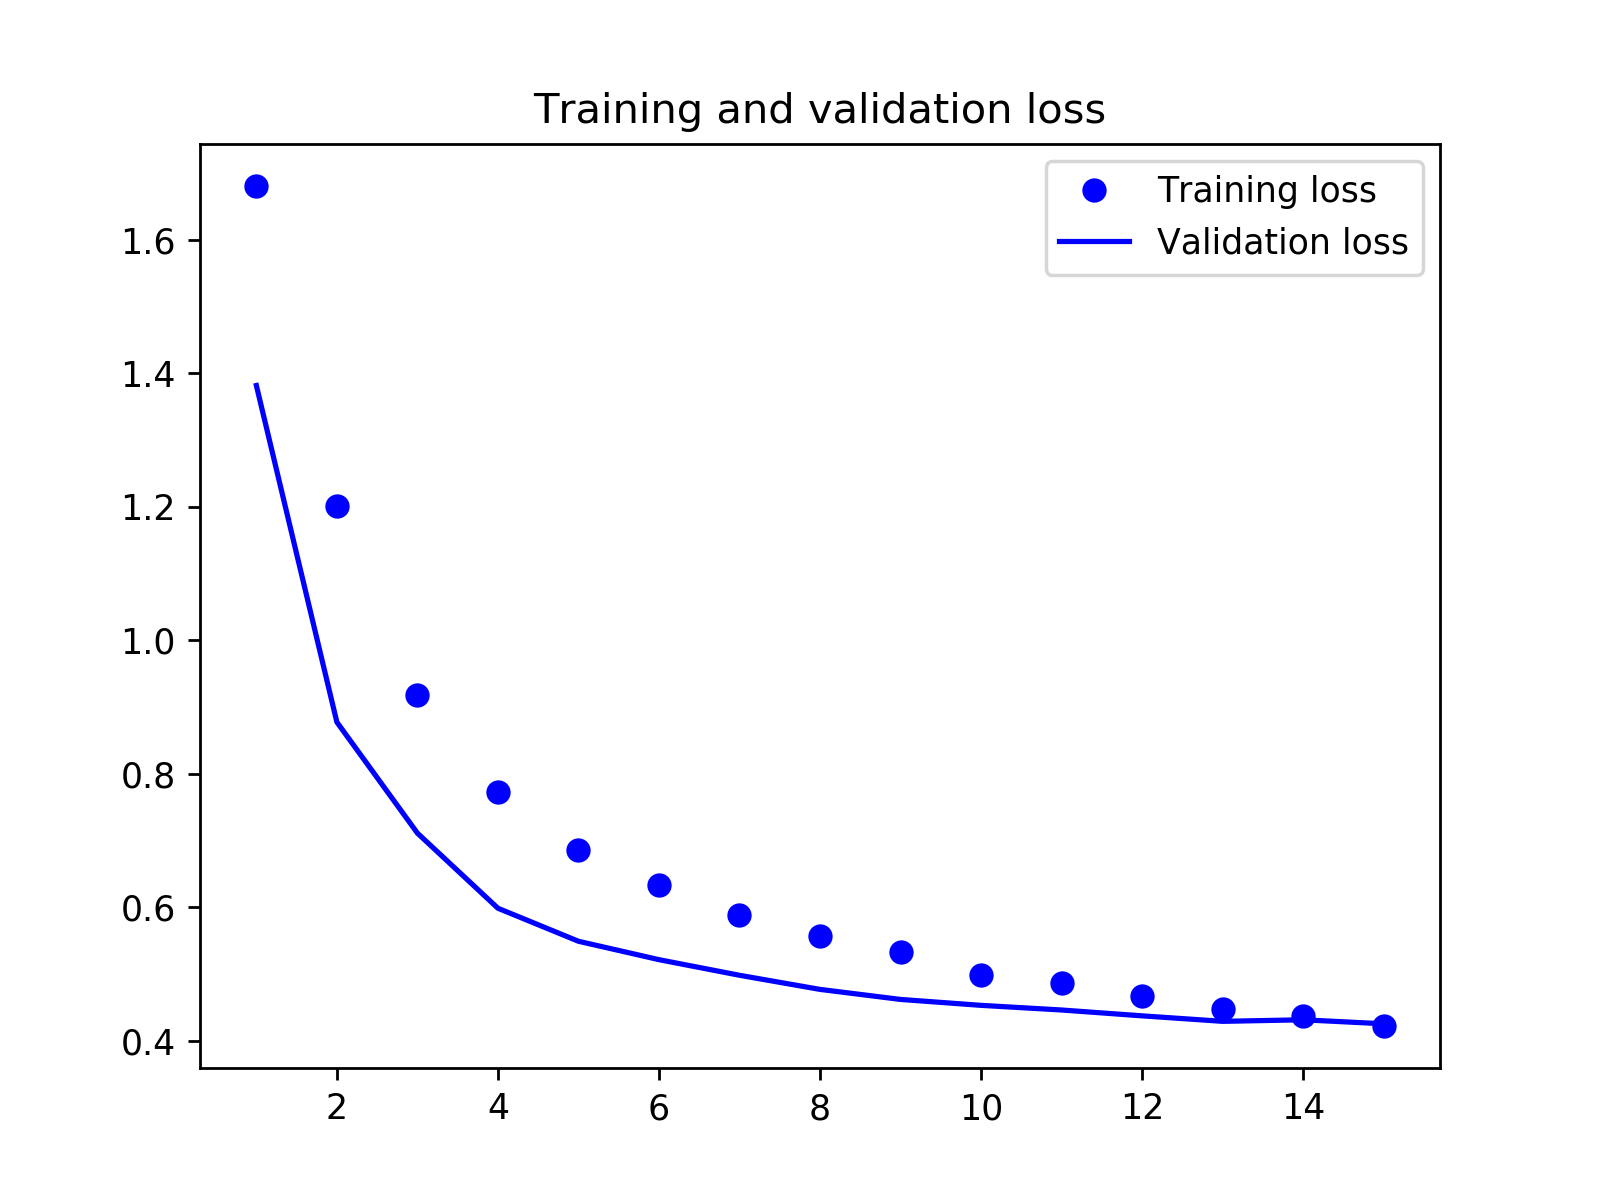

In [22]:
import matplotlib.pyplot as plt
%matplotlib notebook

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can see that the loss and accuracy of the validation set cenverges to that of the trainning set - as it should.

Now we'll look at the model performance for each class (and also at the f1 scores):

In [23]:
from sklearn.metrics import classification_report

y_pred = []
y_true = []
test_pred = model.predict(X_test)

for pred_arr in test_pred:
    pred = np.argmax(pred_arr)
    y_pred.append(pred)
    
for true_arr in y_test:
    true = np.argmax(true_arr)
    y_true.append(true)
    
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1247
           1       0.82      0.84      0.83      1213
           2       0.86      0.89      0.87      1207
           3       0.87      0.82      0.85      1257
           4       0.83      0.83      0.83      1286
           5       0.89      0.90      0.89      1246

   micro avg       0.87      0.87      0.87      7456
   macro avg       0.87      0.87      0.87      7456
weighted avg       0.87      0.87      0.87      7456



We can see that the model performs well for all labels 

## Examples

Here are some examples, we can see that the model classifies correctly

In [24]:
code = ["model = KNeighborsClassifier(n_neighbors=3)\n model.fit(x, y)"]
seq = tokenizer.texts_to_sequences(code)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
labels = ['Load', 'Prep', 'Train', 'Eval', 'Explore', 'Import']
print(pred, labels[np.argmax(pred)])

[[7.3060568e-05 1.2150279e-03 9.9475682e-01 3.4891251e-03 2.4327965e-04
  2.2272921e-04]] Train


In [25]:
code = ["import library\nimport otherlibrary"]
seq = tokenizer.texts_to_sequences(code)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
print(pred, labels[np.argmax(pred)])

[[0.00193848 0.00310283 0.00109321 0.01201025 0.00307849 0.97877675]] Import


In [26]:
code = ["df = pd.read_csv('file')"]
seq = tokenizer.texts_to_sequences(code)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
print(pred, labels[np.argmax(pred)])

[[0.5997012  0.00940495 0.00401655 0.0045712  0.01342174 0.36888438]] Load


In [27]:
code = ["df.shape\ndf.head()"]
seq = tokenizer.texts_to_sequences(code)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
print(pred, labels[np.argmax(pred)])

[[1.3007352e-03 7.6575339e-04 3.8531951e-05 1.5432638e-04 9.9762315e-01
  1.1755567e-04]] Explore


In [28]:
code = ["accr = model.evaluate(X_test,y_test) print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))"]
seq = tokenizer.texts_to_sequences(code)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
print(pred, labels[np.argmax(pred)])

[[3.1216902e-04 5.2349521e-03 2.5728725e-02 9.6441144e-01 3.1869861e-03
  1.1258071e-03]] Eval


You can try yourself by enetering a cells code:

In [ ]:
code = ["INSERT CODE HERE"]
seq = tokenizer.texts_to_sequences(code)
padded = pad_sequences(seq, maxlen=max_len)
pred = model.predict(padded)
print(pred, labels[np.argmax(pred)])